***BGS Core Machine learning project - using unet as implemented by fastai***

In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES']=''

*Import libraries needed - os variable is used for debugging problems with torch and cuda - cpu shows errors more clearly*

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from torchvision import transforms
import matplotlib.pyplot as plt

*Show files in path*

In [4]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
path = Path('/home/ubuntu/BGS_DS/Data')
path.ls()

[PosixPath('/home/ubuntu/BGS_DS/Data/images'),
 PosixPath('/home/ubuntu/BGS_DS/Data/masks_converted_uncropped'),
 PosixPath('/home/ubuntu/BGS_DS/Data/7thDS'),
 PosixPath('/home/ubuntu/BGS_DS/Data/T3ESJ6Gpo3pro00ped_011..1CP_.png'),
 PosixPath('/home/ubuntu/BGS_DS/Data/test'),
 PosixPath('/home/ubuntu/BGS_DS/Data/Cropped_Images'),
 PosixPath('/home/ubuntu/BGS_DS/Data/TE_rp0P0_p8..G21C6dJpS02o9eo.png'),
 PosixPath('/home/ubuntu/BGS_DS/Data/masks_complete_labels'),
 PosixPath('/home/ubuntu/BGS_DS/Data/SJT21pp0od98PeE0__Gr1.p11o.C.png'),
 PosixPath('/home/ubuntu/BGS_DS/Data/images_complete_labels'),
 PosixPath('/home/ubuntu/BGS_DS/Data/Test_Images'),
 PosixPath('/home/ubuntu/BGS_DS/Data/.ipynb_checkpoints'),
 PosixPath('/home/ubuntu/BGS_DS/Data/modded_masks'),
 PosixPath('/home/ubuntu/BGS_DS/Data/images_coloured_masks'),
 PosixPath('/home/ubuntu/BGS_DS/Data/masks2'),
 PosixPath('/home/ubuntu/BGS_DS/Data/coloured_masks'),
 PosixPath('/home/ubuntu/BGS_DS/Data/Cropped_Masks'),
 PosixPath('/ho

*Add paths for different datasets*

In [5]:
path_lbl = path/'coloured_masks'
path_img = path/'images_coloured_masks'
path_test = path/'7thDS'
path_full = path/'Full_Dataset'
path_save = path/'Test_Images'

**Load Data and Check Directories**

In [6]:
fnames = get_image_files(path_img)
fnames[:3]
len(fnames)

33

In [7]:
fnames = get_image_files(path_lbl)
fnames[:3]
len(fnames)

33

*Show masks - png masks show up as black*

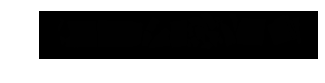

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

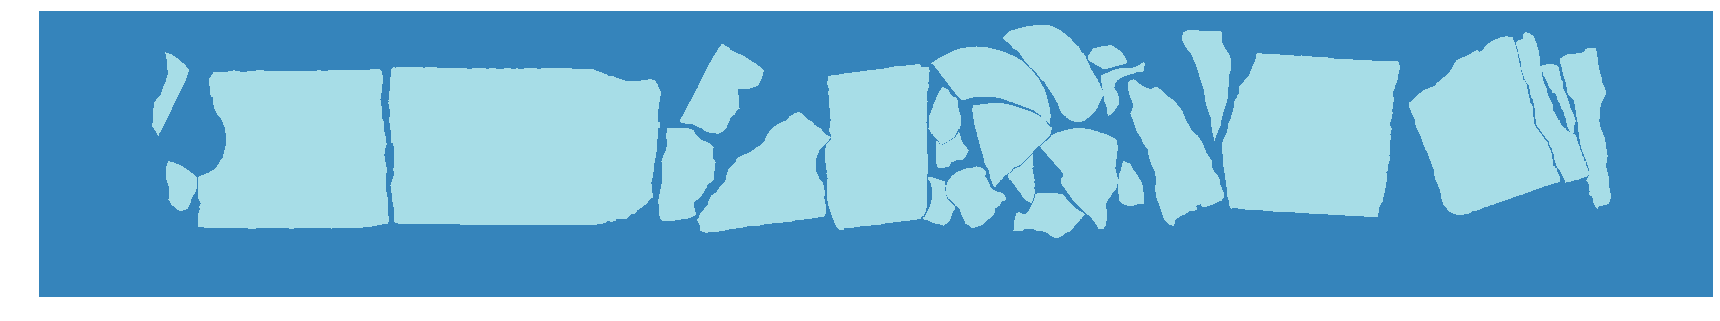

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(30,30), alpha=0.9)

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([1188, 6960]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

*Generate a text file with codes and validation*

In [12]:
!rm codes.txt
!touch codes.txt
!echo "Box\nRockFragment\nPaper\nCorePlug\nText\nVoid" > codes.txt
!pwd
!ls
!cat codes.txt
!cat valid.txt

/home/ubuntu/BGS_DS
Data				    UnetBGS.ipynb
Full_Images.tar			    Validation_Data.pdf
ImageFullTest.zip		    codes.txt
Prediction_Less_Synthetic_Data.pdf  outfile.png.npy
Prediction_No_Synthetic_Data1.pdf   plots
Prediction_Synthetic_Data.pdf	    results.pdf
Processed_Image.pdf		    results_with_Edges.pdf
Processed_Image2.pdf		    results_with_Synthetic_Data.pdf
Raw_Data.pdf			    results_with__less_Synthetic_Data.pdf
Raw_Data2.pdf			    results_with__no_Synthetic_Data.pdf
Test_Plastic.pdf		    someimage.jpeg
UnetBGS-Second_Test-Copy1.ipynb     someimage.png
UnetBGS-Second_Test.ipynb	    valid.txt
Box
RockFragment
Paper
CorePlug
Text
Void
S00128910.Cropped_Top_2.png
S00128806.Cropped_Top_2.png
S00128918.Cropped_Top_2.png
S00131325.Cropped_Top_1.png


In [13]:
codes = np.loadtxt('/home/ubuntu/BGS_DS/codes.txt', dtype=str); codes

array(['Box', 'RockFragment', 'Paper', 'CorePlug', 'Text', 'Void'], dtype='<U12')

In [14]:
print(codes)

['Box' 'RockFragment' 'Paper' 'CorePlug' 'Text' 'Void']


*Setup databunch decide image size and batch size*

In [15]:
#size = src_size//2
import numpy as np
print((src_size))
#size = np.array([90,620])
size = np.array([360,2480])
print(size)
bs=1


[1188 6960]
[ 360 2480]


In [16]:

src = (SegmentationItemList.from_folder('/home/ubuntu/BGS_DS/Data/images_coloured_masks/')
       .split_by_fname_file('/home/ubuntu/BGS_DS/valid.txt')
       .label_from_func(get_y_fn, classes=['Box','Rock','Paper','Plug','Text','Void']))

In [17]:
src.train.y.create_func = partial(open_mask, div=True)
src.valid.y.create_func = partial(open_mask, div=True)
for i in (src.train.x[0].data):
    print(i)

tensor([[0.0118, 0.0118, 0.0118,  ..., 0.0667, 0.0667, 0.0667],
        [0.0118, 0.0118, 0.0118,  ..., 0.0627, 0.0627, 0.0627],
        [0.0118, 0.0118, 0.0118,  ..., 0.0549, 0.0549, 0.0549],
        ...,
        [0.2196, 0.2196, 0.2196,  ..., 0.0078, 0.0078, 0.0039],
        [0.2196, 0.2196, 0.2196,  ..., 0.0078, 0.0078, 0.0039],
        [0.2196, 0.2196, 0.2196,  ..., 0.0078, 0.0078, 0.0039]])
tensor([[0.1216, 0.1216, 0.1216,  ..., 0.0627, 0.0627, 0.0627],
        [0.1216, 0.1216, 0.1216,  ..., 0.0588, 0.0588, 0.0588],
        [0.1216, 0.1216, 0.1216,  ..., 0.0510, 0.0510, 0.0510],
        ...,
        [0.2588, 0.2588, 0.2588,  ..., 0.0627, 0.0627, 0.0588],
        [0.2588, 0.2588, 0.2588,  ..., 0.0627, 0.0627, 0.0588],
        [0.2588, 0.2588, 0.2588,  ..., 0.0627, 0.0627, 0.0588]])
tensor([[0.2078, 0.2078, 0.2078,  ..., 0.0549, 0.0549, 0.0549],
        [0.2078, 0.2078, 0.2078,  ..., 0.0510, 0.0510, 0.0510],
        [0.2078, 0.2078, 0.2078,  ..., 0.0431, 0.0431, 0.0431],
        ...,

In [18]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

*Show part of validation set and the training data*

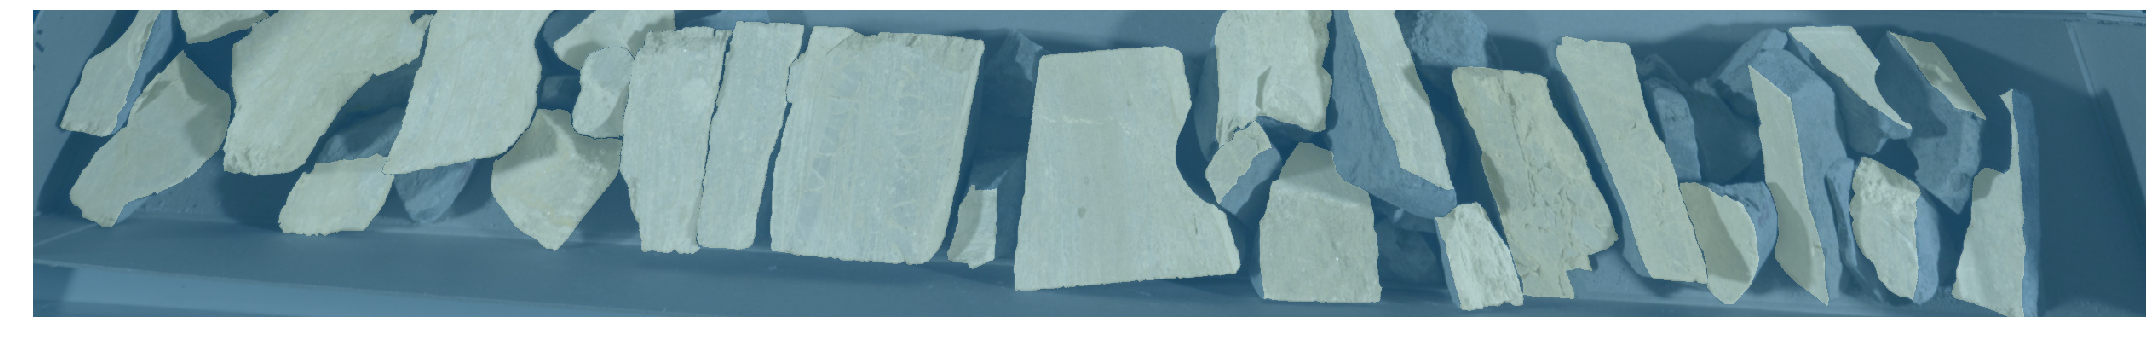

In [19]:
data.show_batch(1, figsize=(30,30))
#plt.savefig("Raw_Data2.pdf")

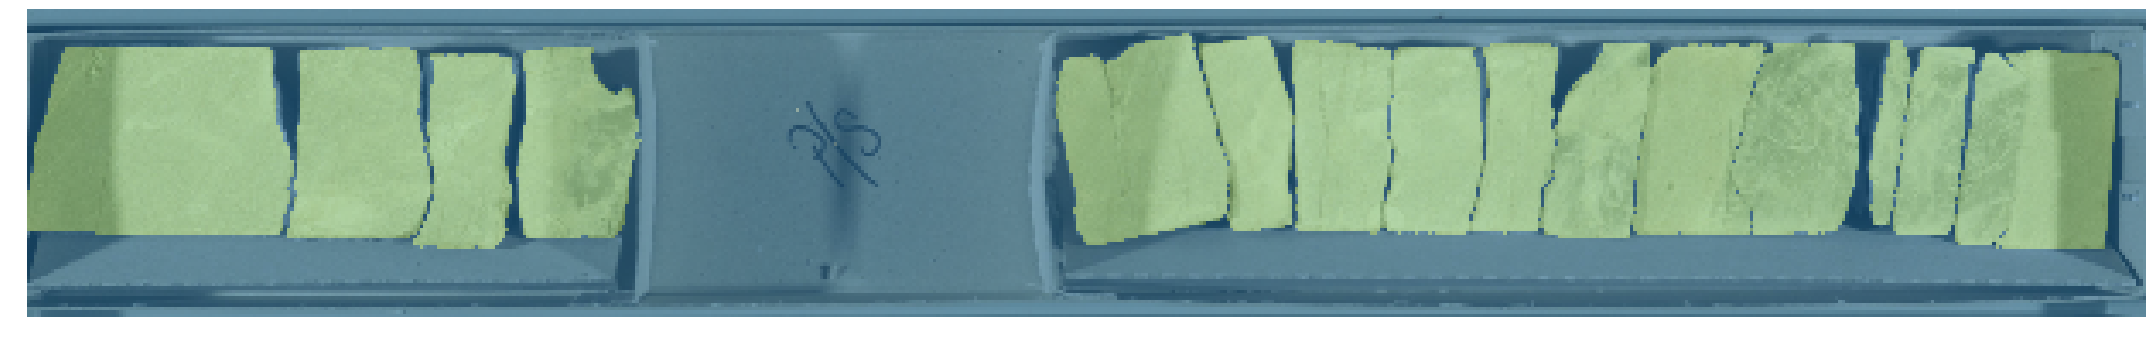

In [20]:
data.show_batch(1, figsize=(30,30), ds_type=DatasetType.Valid)
#plt.savefig("Validation_Data.pdf")

*Accuracy metric like what is implemented in the fastai tutorial - needs to be changed eventually*

In [20]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']
print(name2id)
def acc_rock(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

{'Box': 0, 'RockFragment': 1, 'Paper': 2, 'CorePlug': 3, 'Text': 4, 'Void': 5}


In [21]:
metrics=acc_rock

In [22]:
wd=1e-2

*Setup learner and find optimal learning rate*

In [23]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
learn.model = torch.nn.DataParallel(learn.model)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-05


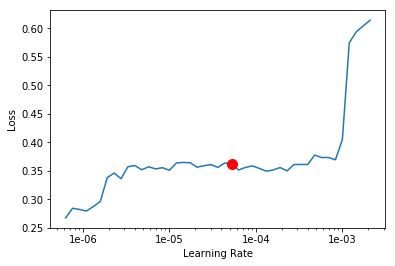

In [26]:
lr_find(learn)
learn.recorder.plot()

In [27]:
lr=5.20E-05

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

In [ ]:
learn.save('stage-1-87acc_LowerPixelQ')

In [26]:
learn.load('stage-1-87acc_LowerPixelQ')

Learner(data=ImageDataBunch;

Train: LabelList (29 items)
x: SegmentationItemList
Image (3, 90, 620),Image (3, 90, 620),Image (3, 90, 620),Image (3, 90, 620),Image (3, 90, 620)
y: SegmentationLabelList
ImageSegment (1, 90, 620),ImageSegment (1, 90, 620),ImageSegment (1, 90, 620),ImageSegment (1, 90, 620),ImageSegment (1, 90, 620)
Path: /home/ubuntu/BGS_DS/Data/images_coloured_masks;

Valid: LabelList (4 items)
x: SegmentationItemList
Image (3, 90, 620),Image (3, 90, 620),Image (3, 90, 620),Image (3, 90, 620)
y: SegmentationLabelList
ImageSegment (1, 90, 620),ImageSegment (1, 90, 620),ImageSegment (1, 90, 620),ImageSegment (1, 90, 620)
Path: /home/ubuntu/BGS_DS/Data/images_coloured_masks;

Test: None, model=DataParallel(
  (module): DynamicUnet(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): 

In [ ]:
learn.show_results(rows=2, figsize=(24,24))
#plt.savefig("results_with__no_Synthetic_Data.pdf")

In [27]:
learn.unfreeze()

In [30]:
lrs = slice(lr/400,lr/4)

In [31]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_rock
1,0.245386,0.328491,0.876290
2,0.234281,0.327239,0.877133
3,0.234920,0.320977,0.879485
4,0.238939,0.306199,0.885824
5,0.236045,0.327454,0.876510
6,0.235699,0.309355,0.883212
7,0.234571,0.310196,0.882115
8,0.234879,0.316596,0.877200
9,0.232181,0.327036,0.873002
10,0.232643,0.297857,0.890081


In [32]:
learn.save('stage-2-small');

In [25]:
learn.load('stage-2-small');

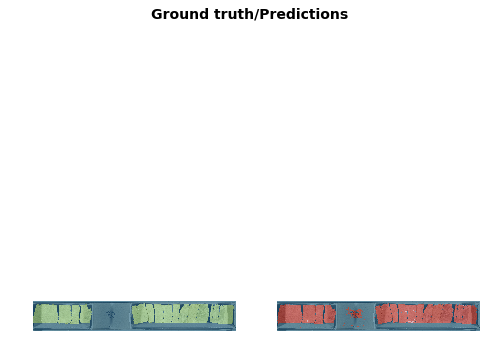

In [30]:
learn.show_results(rows=2, figsize=(8,9))

In [40]:
img = open_image('/home/ubuntu/BGS_DS/Data/test/cjuy39l3k4so60888v6m38oq1.jpeg')
img = img.resize((3,360,2480))

In [42]:
img = open_image('/home/ubuntu/BGS_DS/Data/test/cjuy3a4ls4t9c08882n2u9x2t.jpeg')
img = img.resize((3,360,2480))

***Prediction on a difficult image***

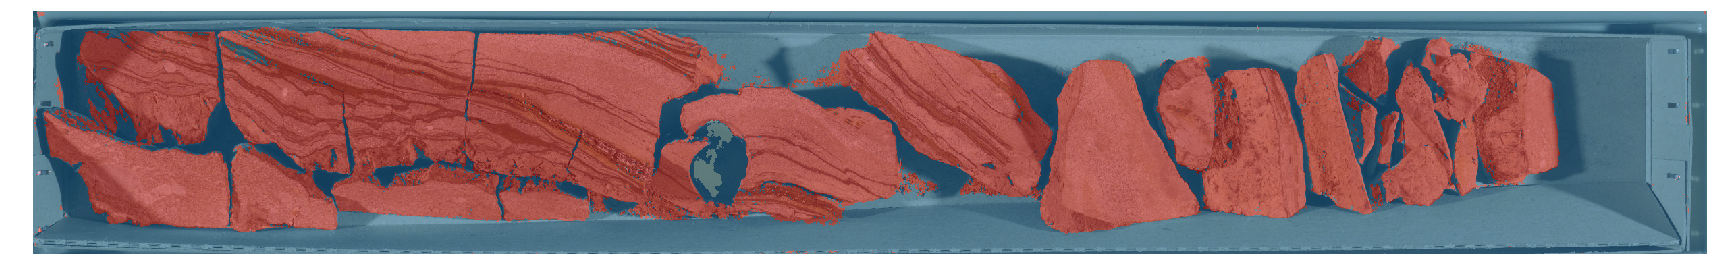

In [43]:
img.show(y=learn.predict(img)[0],figsize=(30,30))
#plt.savefig("Processed_Image2.pdf")

In [28]:
learn.fit_one_cycle(10,lr,pct_start=0.9)

epoch,train_loss,valid_loss,acc_rock
1,0.334721,0.519708,0.806962
2,0.321605,0.543927,0.814669
3,0.300994,0.476138,0.830265
4,0.278513,0.445266,0.839007
5,0.268646,0.455582,0.839174
6,0.284950,0.429278,0.835156
7,0.260790,0.437919,0.832555
8,0.243676,0.517570,0.820721
9,0.238235,0.525656,0.828550
10,0.217376,0.356880,0.872566


In [33]:
learn.save('stage-1-big')

In [34]:
learn.unfreeze()

In [35]:
lrs = slice(1e-6,lr/10)

***Final training with the larger images***

In [36]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_rock
1,0.180571,0.371942,0.868500
2,0.165428,0.433809,0.854037
3,0.167791,0.410724,0.857235
4,0.165231,0.454202,0.844381
5,0.157939,0.375535,0.864706
6,0.161893,0.331024,0.879606
7,0.158895,0.352335,0.873858
8,0.155144,0.437846,0.854552
9,0.155075,0.365722,0.870376
10,0.155518,0.359077,0.872279


In [37]:
learn.save('stage-2-big')

In [38]:
learn.load('stage-2-big');

In [35]:
img = open_image('/home/ubuntu/BGS_DS/Data/test/cjv0zdfrmfb2k09372lhu949t.jpeg')
img = img.resize((3,360,2480))

In [ ]:
prediction = learn.predict(img)
dir(prediction[0])

In [ ]:
prediction[0].show(figsize=(30,24))
plt.savefig("Prediction_No_Synthetic_Data1.pdf",figsize=(30,24))

In [ ]:
plt.imshow(image2np(img.data))
plt.savefig("Test_Plastic.pdf",figsize=(30,24))

In [ ]:
print(prediction)

**Do batch Processing and save the predictions**

In [44]:
fnames = get_image_files(path_full)
fnames[34]
print(os.path.splitext(fnames[34]))
print(fnames[0].stem)
print(str(path_save)+str(fnames[0].stem))

('/home/ubuntu/BGS_DS/Data/Full_Dataset/S00128907.Cropped_Top_1', '.JPEG')
S00128918.Cropped_Top_2
/home/ubuntu/BGS_DS/Data/Test_ImagesS00128918.Cropped_Top_2


In [82]:
def saveMasks(fname):
    file, ext = os.path.splitext(fname)
    img = open_image(fname)
    img = img.resize((3,360,2480))
    img.show(y=learn.predict(img)[0],title=fname.stem,figsize=(30,30))
    plt.savefig(str(path_save)+"/"+fname.stem+".pdf")
    plt.clf()
    image = learn.predict(img)
    image = image2np(image[1]).astype(np.uint8)
    image = PIL.Image.fromarray((image), mode='L')
    image.save(str(path_save)+"/"+fname.stem+".png")

In [83]:
for i in range(len(fnames)):
    saveMasks(fnames[i])


/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly 

/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly 

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

<Figure size 2160x2160 with 0 Axes>

/home/ubuntu/BGS_DS/Data/Full_Dataset/S00128907.Cropped_Top_1.JPEG


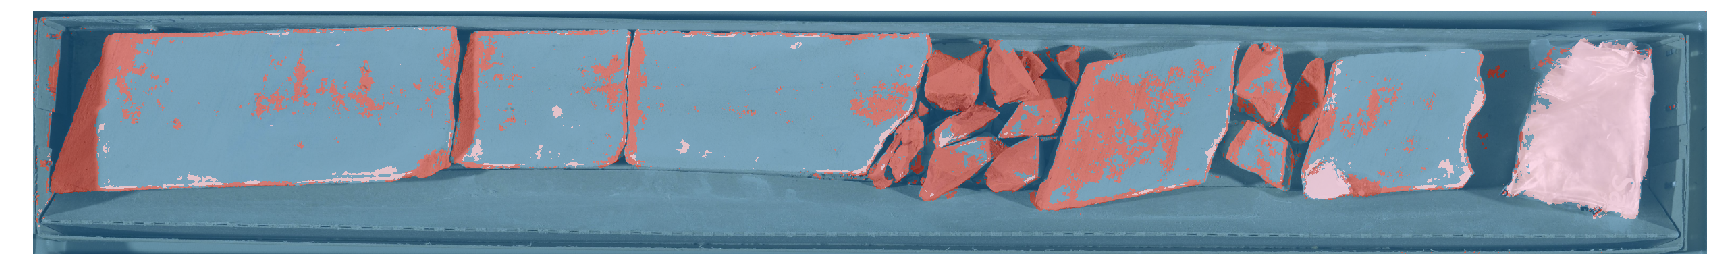

In [79]:
print(fnames[34])
img = open_image(fnames[34])
img = img.resize((3,360,2480))
img.show(y=learn.predict(img)[0],figsize=(30,30))


In [ ]:
image = learn.predict(img)
image = image2np(image[1]).astype(np.uint8)

***Do the saving bit - resize the original files into the trained model size - this way the masks and images fit***

In [92]:
fnames = get_files(path_save)
#fnames = get_files(path_full)


In [93]:
print(fnames[:3])

[PosixPath('/home/ubuntu/BGS_DS/Data/Test_Images/S00128908.Cropped_Top_1.pdf'), PosixPath('/home/ubuntu/BGS_DS/Data/Test_Images/S00128757.Cropped_Top_1.png'), PosixPath('/home/ubuntu/BGS_DS/Data/Test_Images/CB00110149.Cropped_Top_1.pdf')]


In [90]:
for i in fnames:
    img = open_image(i)
    img = img.resize((3,360,2480))
    img.save(str(path_save)+"/"+i.stem+"_resized.png")

***Tar the files for easier download***

In [94]:
import tarfile
tar = tarfile.open("Full_Images3.tar", "w")
for name in fnames:
    tar.add(name)
tar.close()